In [1]:
#importing modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format ='retina'
%matplotlib inline

In [2]:
df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
#function for missing value imputation

def impute_median(data):
    return data.fillna(data.median())

#median imputation

df.glucose = df['glucose'].transform(impute_median)
df.education = df['education'].transform(impute_median)
df.heartRate = df['heartRate'].transform(impute_median)
df.totChol = df['totChol'].transform(impute_median)
df.BPMeds = df['BPMeds'].transform(impute_median)

## group by classes that are in relation with other classes

by_currentSmoker = df.groupby(['currentSmoker'])
df.cigsPerDay = by_currentSmoker['cigsPerDay'].transform(impute_median)

by_age = df.groupby(['male','age'])
df.BMI = by_age['BMI'].transform(impute_median)

In [5]:
len(df[df.TenYearCHD> 0])

644

In [6]:
len(df[df.TenYearCHD==0])

3596

In [7]:
#Age encoding
def encode_age(data):
    if data <= 40:
        return 0
    if data > 40 and data <=55:
        return 1
    else:
        return 2    

#heart rate encoder
def heartrate_enc(data):
    if data <= 60:
        return 0
    if data > 60 and data <=100:
        return 1
    else:
        return 2

#applying functions
df['enc_hr'] = df['heartRate'].apply(heartrate_enc)
df['encode_age'] = df['age'].apply(lambda x : encode_age(x))

In [9]:
#Log Transform Continuous Variables
df_copy = df.copy()
df_copy['log_cigsPerDay'] = np.log1p(df_copy['cigsPerDay'])
df_copy['log_totChol'] = np.log1p(df_copy['totChol'])
#df_copy['log_sysBP'] = np.log1p(df_copy['sysBP'])
df_copy['log_diaBP'] = np.log1p(df_copy['diaBP'])
df_copy['log_BMI'] = np.log1p(df_copy['BMI'])
df_copy['log_heartRate'] = np.log1p(df_copy['heartRate'])
df_copy['log_glucose'] = np.log1p(df_copy['glucose'])
df_copy['log_age'] = np.log1p(df_copy['age'])

df_copy.drop(['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'age',
              'currentSmoker', 'education', 'enc_hr', 'encode_age'], axis=1, inplace=True)

In [10]:
#Normalizing dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols = df_copy.drop(['TenYearCHD'], axis=1).columns

norm_df = scaler.fit_transform(df_copy.drop(['TenYearCHD'], axis=1))
norm_df = pd.DataFrame(data=norm_df, columns=cols, index=df_copy.drop(['TenYearCHD'], axis=1).index)                     
norm_df.head()

,male,BPMeds,prevalentStroke,prevalentHyp,diabetes,log_cigsPerDay,log_totChol,log_diaBP,log_BMI,log_heartRate,log_glucose,log_age
0,1.153113,-0.173569,-0.077014,-0.671241,-0.162437,-0.928462,-0.958976,-1.130247,0.366175,0.417050,-0.179487,-1.296260
1,-0.867217,-0.173569,-0.077014,-0.671241,-0.162437,-0.928462,0.389489,-0.094351,0.781994,1.522102,-0.246230,-0.347297
2,1.153113,-0.173569,-0.077014,-0.671241,-0.162437,1.143043,0.279789,-0.182594,-0.042965,0.002631,-0.665854,-0.102079
3,-0.867217,-0.173569,-0.077014,1.489778,-0.162437,1.408036,-0.182514,1.039278,0.747528,-0.914968,1.308555,1.282600
4,-0.867217,-0.173569,-0.077014,-0.671241,-0.162437,1.233898,1.101174,0.164064,-0.648574,0.806637,0.325550,-0.347297


In [13]:
#train-test split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

x = norm_df
y = df_copy['TenYearCHD']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=23)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3180, 12), (1060, 12), (3180,), (1060,))

In [14]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(x_train, y_train)

log_pred = log_reg.predict(x_test)
log_pred

LogisticRegression(solver='liblinear')

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Accuracy Score : 0.8603773584905661
Cross Validation Score :  0.8484276729559749
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       908
           1       0.83      0.03      0.06       152

    accuracy                           0.86      1060
   macro avg       0.85      0.52      0.49      1060
weighted avg       0.86      0.86      0.80      1060



<Axes: >

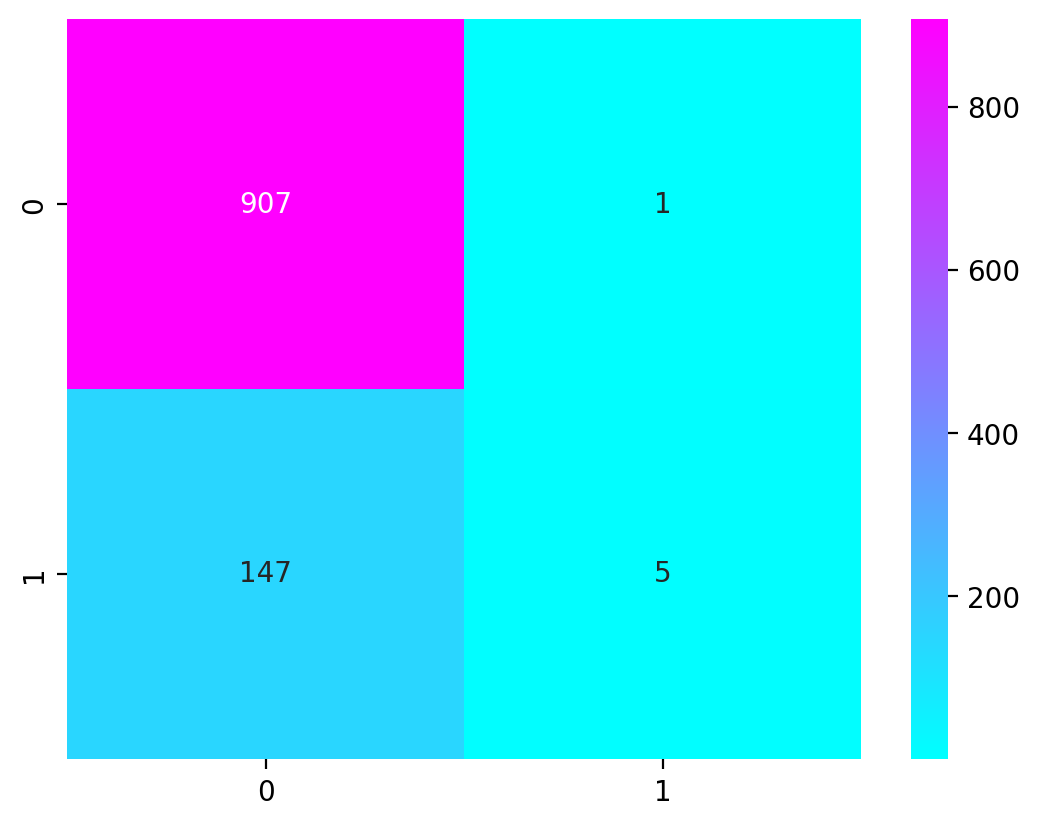

In [15]:
#Metrics Evaluation

print ('Accuracy Score :', accuracy_score(y_test, log_pred))
print ('Cross Validation Score : ', cross_val_score(log_reg, x_train, y_train, cv=5).mean())
print (classification_report(y_test, log_pred))

sns.heatmap(confusion_matrix(y_test, log_pred), annot=True, cmap='cool', fmt='d')

In [17]:
#Applying SMOTE
# import SMOTE module from imblearn library
# from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='not majority')
x_s_res, y_s_res = smote.fit_sample(x_train, y_train)

print (y_train.value_counts(), '\n')
np.bincount(y_s_res)


NameError: name 'SMOTE' is not defined

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (c:\Users\Sandeep\Downloads\ftaminghamClassifier-master\heartclassifier\lib\site-packages\sklearn\utils\_param_validation.py)

In [19]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
from imblearn.over_sampling import SMOTE

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (c:\Users\Sandeep\Downloads\ftaminghamClassifier-master\heartclassifier\lib\site-packages\sklearn\utils\_param_validation.py)